# Test the linear regression model with 2 never seen datasets

## 1. Load packages and custom functions

In [2]:
# -*- coding: utf-8 -*-
"""
Updated 27 November 2025
Author: Sylvain Haupert
"""

from IPython import get_ipython
print(__doc__)

# Clear all the variables
get_ipython().run_line_magic('reset', '-sf')

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")
# from pathlib import Path 
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path 
import os
import sys
import numpy as np
from numpy import mean
from sklearn.metrics import r2_score

import seaborn as sns

# maad
from maad.util import heatmap_by_date_and_time

# Close all the figures (like in Matlab)
plt.close("all")

# Import configuration file
sys.path.append(str(Path('../src')))
import config as cfg
import stat_func


Updated 27 November 2025
Author: Sylvain Haupert



### Custom functions

In [3]:
def concordance_correlation_coefficient(y_true, y_pred):
    """
    Concordance correlation coefficient.
    
    (from https://link.springer.com/article/10.1007/s12350-015-0175-7)
    Note that if one of the tests is a reference or “gold standard,” then the bias is based on the difference 
    between the new test’s result and the “true value” of the quantity being measured, 
    and hence a measure of accuracy.10 
    For these cases, the CCC can be said to measure accuracy as well as consistency. 
    But when neither test is a gold standard, it is not appropriate to state that CCC also provides a measure of accuracy.
    
    Parameters
    ----------
    y_true : array-like
        True values.
    y_pred : array-like
        Predicted values.
    Returns
    -------
    ccc : float
        Concordance correlation coefficient.
    
    """
    # initialize df
    df = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
            })
    # Remove NaNs
    df = df.dropna()
    # Pearson product-moment correlation coefficients
    y_true = df['y_true']
    y_pred = df['y_pred']
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2

    return numerator / denominator

# from https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
def plot_pi_ci_manual(t, std_error, n, x, x2, y2, ci=True, pi=True, ax=None):
    """
        Return an axes of confidence bands using a simple approach.
    
    Parameters
    ----------
    t : float
        The t value for the confidence level and degrees of freedom.
    std_error : float
        The standard error of the regression.
    n : int
        The number of observations.
    x : array-like
        The independent variable data.
    x2 : array-like
        The x values for the prediction line.
    y2 : array-like
        The predicted y values for the prediction line.
    ci : bool, optional
        If True, plot the confidence interval band. Default is True.
    pi : bool, optional
        If True, plot the prediction interval band. Default is True.
    ax : matplotlib.axes.Axes, optional
        The axes to plot on. If None, use the current axes. Default is None.
    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes with the confidence and prediction bands plotted.
    ci : array-like
        The confidence interval values.
    pi : array-like
        The prediction interval values.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
        http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    # Confidence Interval (CI)
    if ci:
        ci = t * std_error * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        ax.fill_between(x2, y2 + ci, y2 - ci, color="0.25", edgecolor=None, alpha=0.33)

        
    # Prediction Interval (PI)
    if pi:
        pi = t * std_error * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
        ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--", linewidth=1)
        ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits", linewidth=1)
        ax.plot(x2, y2 + pi, "--", color="0.5", linewidth=1)

    return ax, ci, pi

## 2. Risoux Dataset


In [4]:
"""==============================================================================
    options             
=============================================================================="""
SAVE = True

# Load the configuration file
CONFIG = cfg.load_config('config_publication_risoux.yaml')

GT = CONFIG['ground_truth']

INDICE_TO_DISPLAY = 'nROI' 

# parameters for the regression model found using another dataset
COEF = 0.025 
INTERCEPT = 0.996


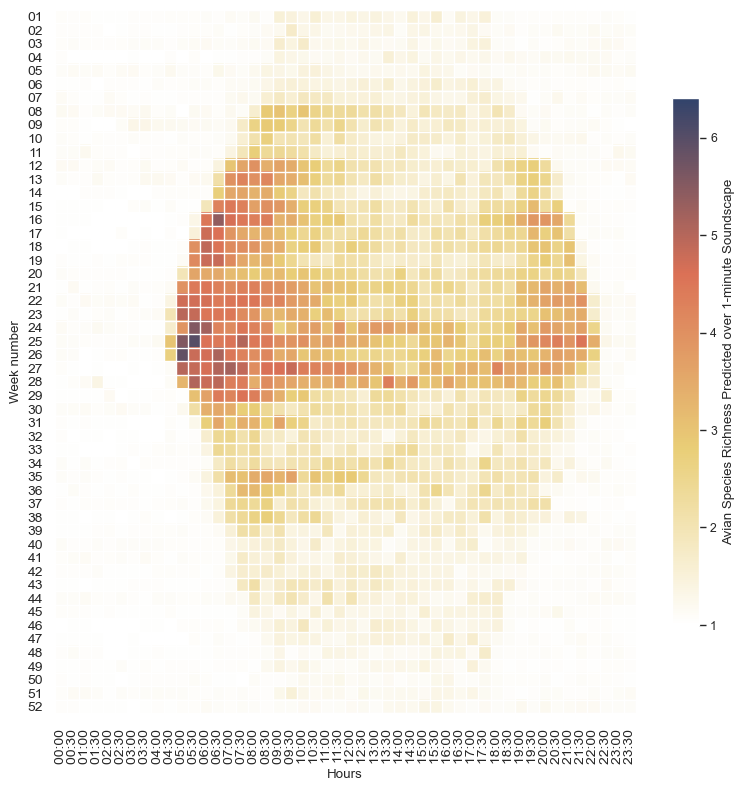

In [5]:
"""============================================================================
    Display heatmap of predicted average avian species richness over one year
    -------------------------------------------------------------------------

    Summary of the steps:
    - Load the acoustic indices calculated over one year at Risoux site
    - Apply the linear regression model to predict avian species richness
    - Display the heatmap of predicted avian species richness over one year
    
============================================================================"""

df_risoux = pd.read_csv(os.path.join(
                            CONFIG['save_dir'], 
                            'indices_full_year_risoux_BWNoneHz_NoneHz_16db.csv'),
                            sep=',')

df_risoux['date'] = pd.to_datetime(df_risoux['Date'])
df_risoux = df_risoux.drop(columns=['Date'])
df_risoux = df_risoux.set_index('date')

# add a column nspecies
df_risoux['Avian Species Richness Predicted over 1-minute Soundscape'] = df_risoux[INDICE_TO_DISPLAY]*COEF + INTERCEPT

from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap: dark green -> yellow -> light green
colors = ["#FFFFFF", "#E9CE77", "#DB7156", "#31436B"]  # dark green, yellow, light green
custom_cmap = LinearSegmentedColormap.from_list('custom_green_yellow', colors)

# change the color map from blue to dark green passing through yellow and light green
_,_, fig, ax = heatmap_by_date_and_time(df_risoux, 
                disp_column = 'Avian Species Richness Predicted over 1-minute Soundscape', 
                date_format = "%V",
                time_resolution='30T',
                start_hour='00:00',
                date_min_to_disp = 1,
                date_max_to_disp = 12,
                figsize=(8,8),
                vmin = np.percentile(df_risoux['Avian Species Richness Predicted over 1-minute Soundscape'], 1),
                vmax = np.percentile(df_risoux['Avian Species Richness Predicted over 1-minute Soundscape'], 99.75),
                cmap=custom_cmap,
                )

# save figure
if SAVE:
    fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_7.png'), dpi=300)

## 3. Wabad Dataset

In [6]:
"""==============================================================================
    options             
=============================================================================="""

SAVE = True

# Load the configuration file
CONFIG = cfg.load_config('config_publication_wabad.yaml')

# variables
GT = CONFIG['ground_truth']
INDICE_TO_DISPLAY = 'nROI'

# parameters for the regression model found using another dataset
# regression coefficient to convert nROI into average species richness
COEF = 0.025 
INTERCEPT = 0.996


In [7]:
"""==============================================================================
    options for display             
=============================================================================="""
PALETTE_NAME = "Set2" 
NUM_COLORS = 8

# set a dictionnary with the color for each habitat
HABITAT_COLOR1 = {
    'Arable land': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0],
    'Forest - Subtropical-tropical moist lowland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[1],
    'Forest - Subtropical-tropical moist montane': sns.color_palette(PALETTE_NAME, NUM_COLORS)[2],
    'Plantations': sns.color_palette(PALETTE_NAME, NUM_COLORS)[3],
    'Forest - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],
    'Shrubland - Subtropical-tropical high altitude': sns.color_palette(PALETTE_NAME, NUM_COLORS)[5],
    'Shrubland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6],
    }

PALETTE_NAME = "tab20" 
NUM_COLORS = 20

# set a dictionnary with the color for each habitat
HABITAT_COLOR2 = {
    'Wetland (inland)': sns.color_palette(PALETTE_NAME, NUM_COLORS)[19],
    'Shrubland - Mediterranean-type': sns.color_palette(PALETTE_NAME, NUM_COLORS)[6], 
    'Forest - Boreal': sns.color_palette(PALETTE_NAME, NUM_COLORS)[0], 
    'Forest - Subtropical-tropical dry': sns.color_palette(PALETTE_NAME, NUM_COLORS)[9], 
    'Shrubland - Subtropical-tropical dry': sns.color_palette(PALETTE_NAME, NUM_COLORS)[14],
    'Pastureland': sns.color_palette(PALETTE_NAME, NUM_COLORS)[8],  
    'Savanna - Dry': sns.color_palette(PALETTE_NAME, NUM_COLORS)[16],  
    'Grassland - Temperate': sns.color_palette(PALETTE_NAME, NUM_COLORS)[4],  
    'Desert - Hot': sns.color_palette(PALETTE_NAME, NUM_COLORS)[10],  
        }

# fusion both dictionnaries
HABITAT_COLOR = {**HABITAT_COLOR1, **HABITAT_COLOR2}

# initialize the list of indices, annotations and sites
INDICES_ALL = []
ANNOTATIONS_ALL = []
SITES_ALL = []

In [8]:
"""==========================================================================
    Prepare the dataframe
    ---------------------

    summary of the steps:
    ---------------------
    - loop over the datasets present in WABAD to get the filenames of the indices 
    and annotations and the selected sites corresponding to each dataset
    - load the indices and annotations csv files
    - prepare the indices and annotations dataframes
    - create a new dataframe by merging the indices and annotations dataframes
    
=========================================================================="""

# loop over the datasets to get the filenames of the indices and annotations and the selected sites corresponding to each dataset
for DATASET in CONFIG['datasets']:

    """***************************************************************************
                    Prepare the configuration for the dataset
    ***************************************************************************"""

    filename_indices = 'indices_'+DATASET['name']+'_BW'+str(DATASET['flim_min'])+'Hz_'+str(DATASET['flim_max'])+'Hz_'+str(CONFIG['seed_level'])+'db'+'.csv'

    INDICES_ALL     += [(filename_indices, CONFIG['save_dir'])]
    ANNOTATIONS_ALL += [(CONFIG['annotations_filename'], os.path.dirname(DATASET['path']))] 
    SITES_ALL       += DATASET['sites']

    # display the dataset name
    print(f'Dataset {DATASET["name"]} is being preparing...')       
    # display the number of sites
    print(f'The dataset {DATASET["name"]} contains {len(DATASET["sites"])} sites \n')


"""****************************************************************************
                                Dataframe creation  
****************************************************************************"""
# LOAD CSV
df_indices = pd.DataFrame()
for indices_csv, indices_dir in INDICES_ALL :
    df_indices = pd.concat([df_indices, pd.read_csv(os.path.join(indices_dir,indices_csv), sep=',')], axis=0)

df_label = pd.DataFrame()
for annotations_csv, annotations_dir in ANNOTATIONS_ALL :
    df_label   = pd.concat([df_label, pd.read_csv(os.path.join(annotations_dir,annotations_csv), sep=',')], axis=0)

# select a site
df_label = df_label[df_label['site'].isin(SITES_ALL)]

print('The initial number of files is {}'.format(len(df_indices)))

# drop clipping rows
if CONFIG['remove_clipping_audio'] :
    df_indices = df_indices[df_indices['clipping'] == 0]
    print('The number of files after removing clipped audio is {} \n'.format(len(df_indices)))

# add a column Filename such as in df_label
df_indices['filename'] = df_indices['file'].apply(lambda x: os.path.basename(x).split('.')[0])
df_indices.drop(['Date','file','clipping'], axis='columns', inplace=True)

# set index
df_indices.set_index('filename', inplace = True)
df_label.set_index('filename', inplace = True)

# keep only richness ('species_richness')
df_label = df_label[[ 'date', 'site', 'device_id', 'biome','species_richness']]

# Rename the column biome into habitat
df_label = df_label.rename(columns={'biome':'habitat'})

# HACK
df_label['species_richness'] = df_label['species_richness'].astype('float')

# Remove  ENRf which is the same as LEQf
try :
    df_indices.drop(['ENRf', 'audio_duration'], axis='columns', inplace=True)
except :
    pass 

# Create H indice, a composite of Ht and Hf
df_indices['H'] = df_indices['Ht'] * df_indices['Hf']
# Rename isome indices
df_indices = df_indices.rename(columns={'NBPEAKS':'NP'})
df_indices = df_indices.rename(columns={'BI':'BIO'})
df_indices = df_indices.rename(columns={'MED':'M'})

# transform the values into float
df_indices = df_indices.select_dtypes(include=['number']).astype('float')

# Create a new df by merging df_indices and df_label
df = pd.merge(df_indices, df_label, on='filename', how='inner')

# display the number of files per dataset
for dataset in CONFIG['datasets'] :
    print(f'The number of files for the dataset {dataset["name"]} is {len(df[df["site"].isin(dataset["sites"])])}')

# display the number of files per habitat and the number of sites per habitat
print('\n')
for habitat in df['habitat'].unique() :
    print(f'The number of files for the habitat {habitat} is {len(df[df["habitat"] == habitat])}')
    print(f'The number of sites for the habitat {habitat} is {len(df[df["habitat"] == habitat]["site"].unique())} \n')

Dataset wabad is being preparing...
The dataset wabad contains 70 sites 

The initial number of files is 1677
The number of files after removing clipped audio is 1552 

The number of files for the dataset wabad is 1552


The number of files for the habitat Forest - Subtropical-tropical moist montane is 208
The number of sites for the habitat Forest - Subtropical-tropical moist montane is 8 

The number of files for the habitat Shrubland - Subtropical-tropical high altitude is 34
The number of sites for the habitat Shrubland - Subtropical-tropical high altitude is 5 

The number of files for the habitat Forest - Subtropical-tropical dry is 178
The number of sites for the habitat Forest - Subtropical-tropical dry is 11 

The number of files for the habitat Forest - Subtropical-tropical moist lowland is 175
The number of sites for the habitat Forest - Subtropical-tropical moist lowland is 9 

The number of files for the habitat Shrubland - Temperate is 71
The number of sites for the habit

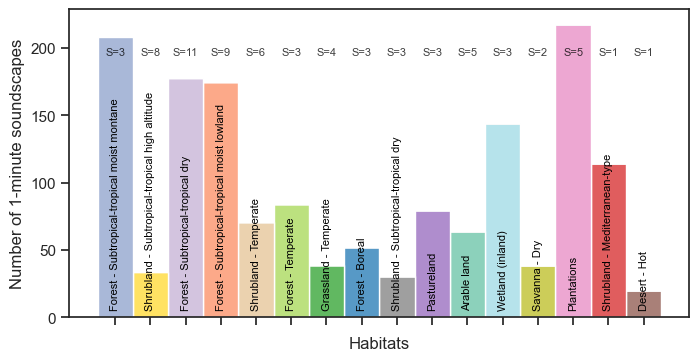

In [9]:
"""==============================================================================
    Display the density of files per habitat             
=============================================================================="""

# display style
sns.set_theme(style="whitegrid")
sns.set_style("ticks")

# plot the density of files for each habitat
fig, ax = plt.subplots(figsize=(8,4))

# display the histogram of the count per habitat and set the legend outside the plot
sns.histplot(df, x='habitat', hue='habitat', multiple='stack', palette=HABITAT_COLOR, ax=ax, legend=False)

# add for each habitat the number of unique site N
n_sites = df.groupby('habitat')['site'].nunique()
# align with plotting order of habitats
order = df['habitat'].value_counts().index.tolist()
n_sites = n_sites.reindex(order).fillna(0).astype(int)

# heights of the histogram bars (number of 1-min soundscapes per habitat)
bar_heights = df['habitat'].value_counts().reindex(order).fillna(0).astype(int)

for i, habitat_name in enumerate(order):
    ax.text(i, int(bar_heights.max())-25, f"S={n_sites.loc[habitat_name]}",
            ha='center', va='bottom', fontsize=8, color='black', alpha=0.75)

# no xtick label
ax.set_xticklabels([])

# add the habitat in each vertical bar of the histogram
# change the police of the text to 8
for i, v in enumerate(df['habitat'].unique()):
    ax.text(i, 7, str(v), color='black', ha='center', fontsize= 8, rotation=90)

# change the horizontal label
ax.set_xlabel('Habitats', fontsize=12)

# change the vertical label
ax.set_ylabel('Number of 1-minute soundscapes', fontsize=12)

plt.show()

# save figure
if SAVE:
    fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_6c.png'), dpi=300)


The number of sites before filtering is 70
The number of sites after fitering is 27


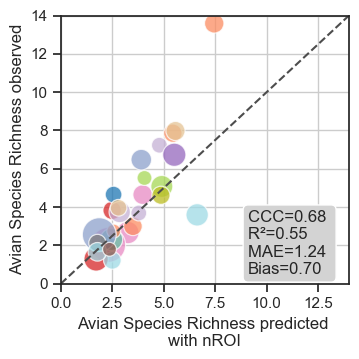

In [19]:
"""==============================================================================
        Group data and compute the correlation the indice and the ground truth
        ----------------------------------------------------------------------

        Adapt the sampling effort number of 1-min audio files per site from
        5 to 20 files per site
        

        Summary of the steps:
        ---------------------
        - Normalize the indice using the linear regression model found on another dataset
        - Group the data by site
        - Remove sites with low sampling effort
        - Compute the mean and std of the indice and ground truth per site
        - Display the goodness of fit between the species richness predicted
        by the model and the species richness observed

=============================================================================="""

# sampling effort adaptation from 3 to 20 files per site
SAMPLING_EFFORT = 20

df_norm = df.copy()
df_norm[INDICE_TO_DISPLAY] = df_norm[INDICE_TO_DISPLAY] * COEF + INTERCEPT

# Use the groupby method to group by the 'site' column
grouped = df_norm.groupby('site')

# Filter numeric columns
numeric_columns = df.select_dtypes(include=[int, float])

# Group by 'site' and calculate the mean for each numeric column
df_count= grouped[numeric_columns.columns].count()
df_mean = grouped[numeric_columns.columns].mean()
df_std  = grouped[numeric_columns.columns].std()

# add a count column to keep the nummber of 1min audio files by site
df_mean['count'] = df_count.iloc[:,0]

"""----------------------------------------------------------------
remove sites with count less than x sampling effort
----------------------------------------------------------------"""

print(f"The number of sites before filtering is {df_mean.shape[0]}")
df_mean = df_mean[df_mean['count']>=SAMPLING_EFFORT]
print(f"The number of sites after fitering is {df_mean.shape[0]}")

"""----------------------------------------------------------------
Create a dictionary from 'df' with 'site' as keys and 'habitat' as values
-----------------------------------------------------------------"""
site_to_habitat = df.set_index('site')['habitat'].to_dict()
# Map the 'habitat' values to df_mean based on 'site'
df_mean['habitat'] = (df_mean.reset_index()['site'].map(site_to_habitat)).to_list()
# Reset the index 'site'
df_mean.reset_index(inplace=True)

"""----------------------------------------------------------------
Display the goodness of fit between the species richness predicted
by the model and the species richness observed
-----------------------------------------------------------------"""

# choose the display style
sns.set_theme(style="whitegrid")
sns.set_style("ticks")

# create a figure and an axis
fig, ax1 = plt.subplots(1, 1)

# change the display order of the plot. Set the Plantations to be the first habitat to display 
df_mean['habitat'] = pd.Categorical(df_mean['habitat'], ['Plantations', 
                                                        'Shrubland - Mediterranean-type',
                                                        'Arable land', 
                                                        'Forest - Subtropical-tropical moist lowland', 
                                                        'Forest - Subtropical-tropical moist montane', 
                                                        'Forest - Temperate', 
                                                        'Shrubland - Subtropical-tropical high altitude', 
                                                        'Forest - Boreal',
                                                        'Forest - Subtropical-tropical dry',
                                                        'Shrubland - Subtropical-tropical dry',
                                                        'Pastureland',
                                                        'Savanna - Dry',
                                                        'Grassland - Temperate',
                                                        'Shrubland - Temperate',
                                                        'Wetland (inland)',
                                                        'Desert - Hot',])

# sort the column habitat to have the same automatic color assignation
df_mean = df_mean.sort_values(by='habitat')

# marker size
# extact the column count from df_mean_by_day, and multiply the values (scalar) by 5
marker_size = df_mean['count'].values*5

# calculate the coefficient of determination
r2 = 1 - sum((df_mean[GT] - df_mean[INDICE_TO_DISPLAY])**2) / sum((df_mean[GT] - mean(df_mean[GT]))**2)
# calculate concordance_correlation_coefficient
ccc = concordance_correlation_coefficient(df_mean[GT], df_mean[INDICE_TO_DISPLAY])
# calculate the MAE : gives an idea of the prediction accuracy
mae = mean(abs(df_mean[GT] - df_mean[INDICE_TO_DISPLAY]))
# calculate the Mean Error ME (= Bias) : evaluate whether predictions are accurate 
# and also whether the model tends to over- or underestimate the values of the variable of interest
me = mean(df_mean[GT] - df_mean[INDICE_TO_DISPLAY])
# rmse
rmse = np.sqrt(mean((df_mean[GT] - df_mean[INDICE_TO_DISPLAY])**2))

# calculate the normalized RMSE
# It provides an indication regarding the dispersion or the variability of the prediction accuracy. 
# It can be related to the variance of the model.
# it is interesting to normalize the RMSE so that this indicator can be expressed as a percentage of the mean of the observations
# nrmse = np.sqrt(mean((df_mean[GT] - df_mean[INDICE_TO_DISPLAY])**2)) / (df_mean[INDICE_TO_DISPLAY].max() - df_mean[INDICE_TO_DISPLAY].min()) * 100

# display the scatterplot
sns.scatterplot(data=df_mean, x=INDICE_TO_DISPLAY, y=GT, 
                hue='habitat', s=marker_size, alpha=0.75,
                palette=HABITAT_COLOR,
                ax=ax1, legend=False)

# set the y limit to 14
ax1.set_ylim(0, 14)
ax1.set_xlim(0, 14)

ax1.grid()
ax1.set_xlabel("Avian Species Richness predicted \nwith %s"%INDICE_TO_DISPLAY)
ax1.set_ylabel("Avian Species Richness observed")
ax1.annotate(
        # "CCC=%.2f \nR²=%.2f \nRMSE=%.2f \nMAE=%.2f \nBias=%.2f" % (ccc ,r2, rmse, mae, me), 
        "CCC=%.2f \nR²=%.2f \nMAE=%.2f \nBias=%.2f" % (ccc ,r2, mae, me), 
        xy=(0.65, 0.15), 
        xycoords='axes fraction', 
        ha='left', 
        va='center', 
        bbox=dict(
                facecolor='lightgrey', 
                edgecolor='white', 
                boxstyle='round')
        )
# add a line y=x, for instance x= 5 y = 5
ax1.plot([0, 15], [0, 15], ls="--", c=".3")

# add a legend with fixed marker size for each habitat and its corresponding color
for HABITAT in df_mean['habitat'].unique():
        ax1.scatter([], [], c=HABITAT_COLOR[HABITAT], label=HABITAT, marker='s', s=40)

# add bubble size legend
bubble_sizes = [15, 30, 50, 100]
bubble_labels = [' 15    samples/site', ' 30    samples/site', ' 50    samples/site', '100   samples/site']
for size, label in zip(bubble_sizes, bubble_labels):
        ax1.scatter([], [], c='white', edgecolor='black', alpha=0.5, s=size*5, label=label)

# Set figure size
fig.set_size_inches((3.75,3.75))
fig.tight_layout()

# save figure
if SAVE:
        if SAMPLING_EFFORT == 5:
                fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_6a.png'), dpi=300)
        elif SAMPLING_EFFORT == 20:
                fig.savefig(os.path.join(CONFIG['save_dir'], 'figure_6b.png'), dpi=300)

In [20]:
rmse

1.7936642161880263